## Step 1: Load and Preprocess Images
This section loads MRI brain tumor images, converts them to grayscale, resizes them to 128x128, and prepares training/testing data.

# Set Up Environment

In [ ]:
!pip install -q opencv-python-headless scikit-image


# Import Required Libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split


## Step 2: Extract HOG and LBP Features
Here we extract edge-based (HOG) and texture-based (LBP) features from the preprocessed images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/brain_tumor_dataset.zip" -d "/content/brain_tumor_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/brain_tumor_dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/brain_tumor_dataset/Trainin

Check Folder Structure

In [ ]:
import os

# Check root folder
print("Main folders:", os.listdir("/content/brain_tumor_dataset"))

# Check categories inside Training and Testing
print("Training categories:", os.listdir("/content/brain_tumor_dataset/Training"))
print("Testing categories:", os.listdir("/content/brain_tumor_dataset/Testing"))


Main folders: ['Testing', 'Training']
Training categories: ['pituitary', 'notumor', 'glioma', 'meningioma']
Testing categories: ['pituitary', 'notumor', 'glioma', 'meningioma']


# Preprocess the Images

In [ ]:
import cv2
import numpy as np
import os

# Base path to dataset folders
DATASET_PATH = '/content/brain_tumor_dataset'

# Target image size
IMG_SIZE = 128

# Labels
labels_map = {
    'glioma': 0,
    'meningioma': 1,
    'pituitary': 2,
    'notumor': 3  # or 'no_tumor' if that's how it's named
}

# Function to load and preprocess images
def load_data(folder):
    X = []
    y = []
    for label in labels_map.keys():
        class_folder = os.path.join(folder, label)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(labels_map[label])
            except:
                print(f"Skipped corrupt image: {img_path}")
    return np.array(X), np.array(y)


## Step 3: Train SVM Models
This section trains Support Vector Machine classifiers using both linear and RBF kernels with different feature sets.

In [ ]:
# Load training data
X_train, y_train = load_data(os.path.join(DATASET_PATH, 'Training'))

# Load testing data
X_test, y_test = load_data(os.path.join(DATASET_PATH, 'Testing'))

# Check shapes
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (5712, 128, 128) (5712,)
Testing set: (1311, 128, 128) (1311,)


# Visualize the Preprocessed Images

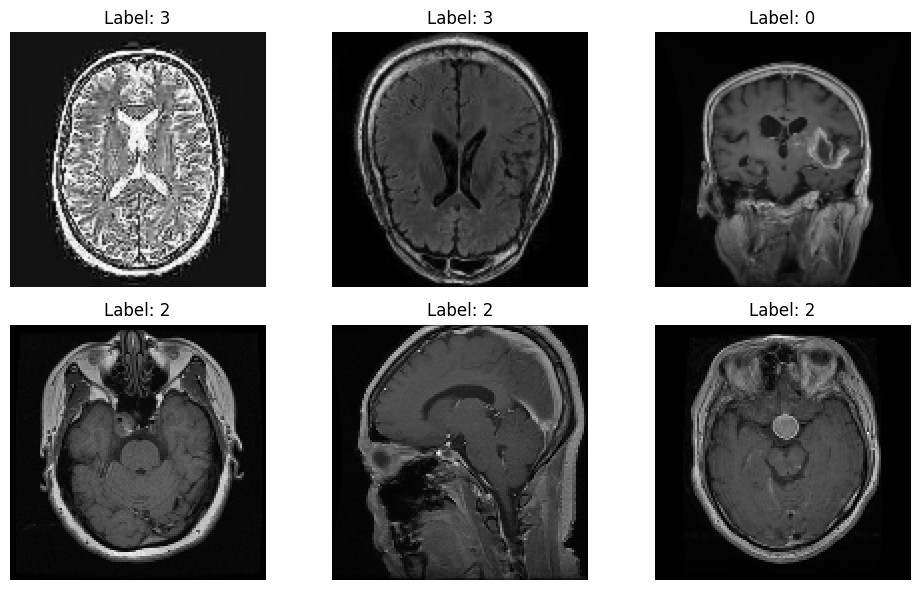

In [ ]:
import random

# Randomly pick 6 image indices
random_indices = random.sample(range(len(X_train)), 6)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Feature Extraction (HOG + LBP)


In [ ]:
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm  # shows a progress bar

# Parameters for LBP
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

# Feature extraction function
def extract_features(images):
    hog_features = []
    lbp_features = []

    for img in tqdm(images):  # tqdm adds a loading bar
        # --- HOG ---
        # Extract edges and shapes
        hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

        # --- LBP ---
        # Extract texture
        lbp = local_binary_pattern(img, LBP_POINTS, LBP_RADIUS, method='uniform')
        # Convert LBP matrix into a histogram (frequency of each pattern)
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, LBP_POINTS + 3),
                                 range=(0, LBP_POINTS + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalize

        hog_features.append(hog_feat)
        lbp_features.append(hist)

    return np.array(hog_features), np.array(lbp_features)


In [ ]:
hog_train, lbp_train = extract_features(X_train)
hog_test, lbp_test = extract_features(X_test)


100%|██████████| 1311/1311 [00:14<00:00, 90.22it/s] 


## Step 4: Evaluate Model Performance
We evaluate each model using accuracy, confusion matrix, and classification reports.

In [ ]:
print("HOG shape (train):", hog_train.shape)
print("LBP shape (train):", lbp_train.shape)
print("HOG shape (test):", hog_test.shape)
print("LBP shape (test):", lbp_test.shape)


HOG shape (train): (5712, 8100)
LBP shape (train): (5712, 10)
HOG shape (test): (1311, 8100)
LBP shape (test): (1311, 10)


# Train Linear SVM (HOG only & HOG+LBP)

# Train SVM Classifier

In [ ]:
# Use only 1000 samples for fast testing
from sklearn.utils import shuffle
X_sample, y_sample = shuffle(hog_train, y_train, random_state=42)
X_test_sample, y_test_sample = shuffle(hog_test, y_test, random_state=42)

X_sample = X_sample[:1000]
y_sample = y_sample[:1000]
X_test_sample = X_test_sample[:300]
y_test_sample = y_test_sample[:300]

# Train fast prototype
svm_fast = SVC(kernel='rbf', C=1, gamma='scale')
svm_fast.fit(X_sample, y_sample)
y_pred_fast = svm_fast.predict(X_test_sample)


In [ ]:
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(hog_train, y_train)


SVC(C=1, kernel='linear')

Evaluate Your Linear SVM

## Step 5: Visualize Model Comparisons
Includes accuracy comparison and metric-based charts (Precision, Recall, F1) for different tumor classes.

Linear SVM Accuracy: 0.9474


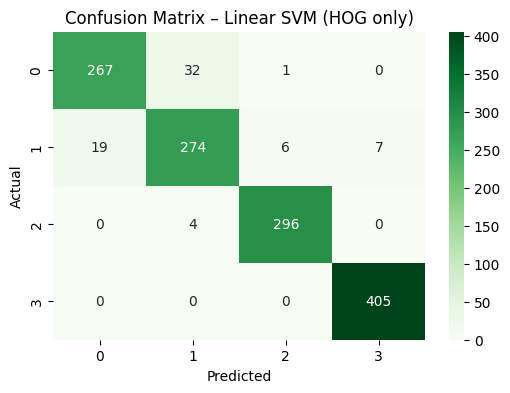

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict test set
y_pred_linear = svm_linear.predict(hog_test)

# Accuracy
acc = accuracy_score(y_test, y_pred_linear)
print(f"Linear SVM Accuracy: {acc:.4f}")

# Confusion Matrix Plot
def plot_cm(true, pred, title):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_cm(y_test, y_pred_linear, "Confusion Matrix – Linear SVM (HOG only)")


# HOG + LBP Combo Training

HOG + LBP Accuracy: 0.9481


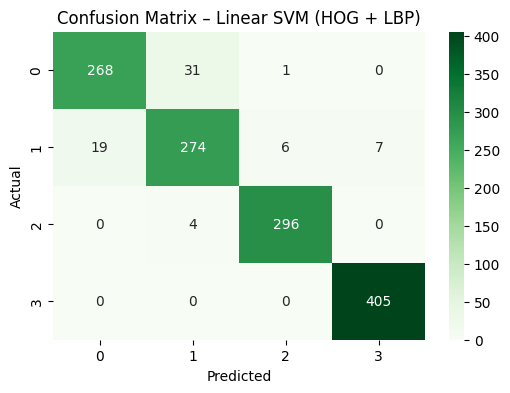

In [ ]:
# Combine HOG + LBP features
X_train_combined = np.hstack((hog_train, lbp_train))
X_test_combined = np.hstack((hog_test, lbp_test))

# Train linear SVM with combined features
svm_combined = SVC(kernel='linear', C=1)
svm_combined.fit(X_train_combined, y_train)

# Predict and evaluate
y_pred_combined = svm_combined.predict(X_test_combined)
acc_combined = accuracy_score(y_test, y_pred_combined)
print(f"HOG + LBP Accuracy: {acc_combined:.4f}")

# Plot confusion matrix
plot_cm(y_test, y_pred_combined, "Confusion Matrix – Linear SVM (HOG + LBP)")


# Precision/Recall/F1 score

In [ ]:
from sklearn.metrics import classification_report

# For Linear SVM with HOG only
print("Linear SVM (HOG only):")
print(classification_report(y_test, y_pred_hog, target_names=['glioma', 'meningioma', 'pituitary', 'notumor']))

# For Linear SVM with HOG + LBP
print("Linear SVM (HOG + LBP):")
print(classification_report(y_test, y_pred_combined, target_names=['glioma', 'meningioma', 'pituitary', 'notumor']))


Linear SVM (HOG only):
              precision    recall  f1-score   support

      glioma       0.94      0.85      0.90       300
  meningioma       0.85      0.86      0.86       306
   pituitary       0.94      0.98      0.96       300
     notumor       0.97      1.00      0.99       405

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.93      1311
weighted avg       0.93      0.93      0.93      1311

Linear SVM (HOG + LBP):
              precision    recall  f1-score   support

      glioma       0.93      0.89      0.91       300
  meningioma       0.89      0.90      0.89       306
   pituitary       0.98      0.99      0.98       300
     notumor       0.98      1.00      0.99       405

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



# Train RBF SVM (HOG+LBP)

In [ ]:
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train_combined, y_train)
y_pred_rbf = svm_rbf.predict(X_test_combined)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF SVM Accuracy: {acc_rbf:.4f}")

# Full classification report (precision, recall, F1 for each class)
print("\nClassification Report for RBF SVM:")
print(classification_report(y_test, y_pred_rbf, target_names=['glioma', 'meningioma', 'pituitary', 'notumor']))


RBF SVM Accuracy: 0.9306

Classification Report for RBF SVM:
              precision    recall  f1-score   support

      glioma       0.94      0.85      0.90       300
  meningioma       0.85      0.86      0.86       306
   pituitary       0.94      0.98      0.96       300
     notumor       0.97      1.00      0.99       405

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.93      1311
weighted avg       0.93      0.93      0.93      1311



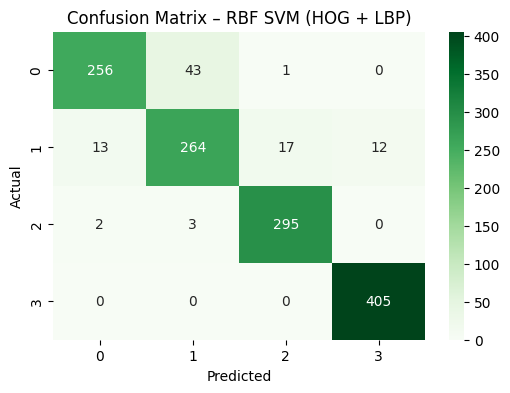

In [ ]:
plot_cm(y_test, y_pred_rbf, "Confusion Matrix – RBF SVM (HOG + LBP)")


# Accuracy Comparison Of SVM Models

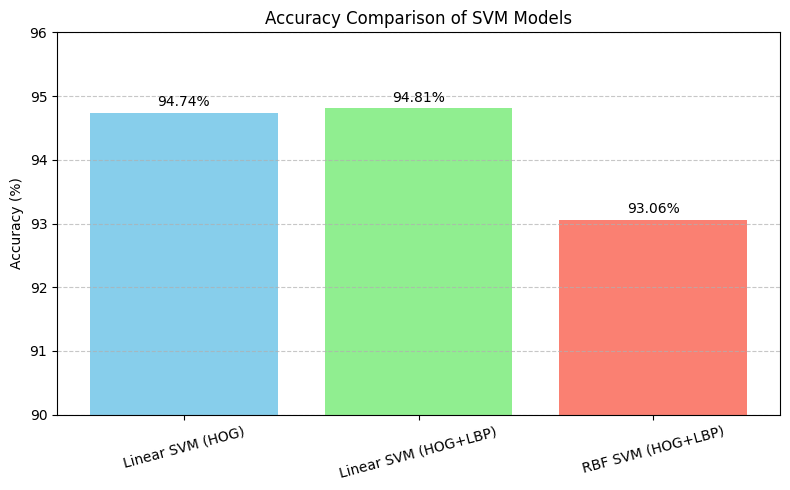

'/mnt/data/accuracy_comparison_graph.png'

In [ ]:
import matplotlib.pyplot as plt

# Data from your results
models = ['Linear SVM (HOG)', 'Linear SVM (HOG+LBP)', 'RBF SVM (HOG+LBP)']
accuracies = [94.74, 94.81, 93.06]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Accuracy Comparison of SVM Models')
plt.ylabel('Accuracy (%)')
plt.ylim(90, 96)

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{acc:.2f}%", ha='center', fontsize=10)

plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()



# Precision, Recall, F1-Score By Class (RBF SVM)

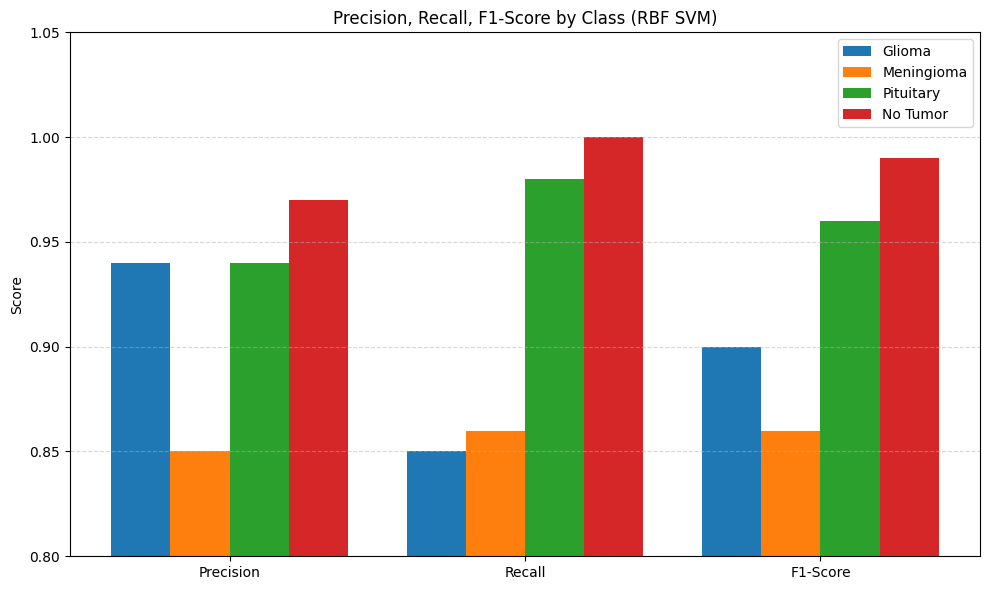

In [ ]:
# Precision, Recall, F1 data (from classification report you shared for RBF)
metrics = ['Precision', 'Recall', 'F1-Score']
glioma = [0.94, 0.85, 0.90]
meningioma = [0.85, 0.86, 0.86]
pituitary = [0.94, 0.98, 0.96]
notumor = [0.97, 1.00, 0.99]

# Grouped bar plot
x = np.arange(len(metrics))  # label locations
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, glioma, width, label='Glioma')
plt.bar(x - 0.5*width, meningioma, width, label='Meningioma')
plt.bar(x + 0.5*width, pituitary, width, label='Pituitary')
plt.bar(x + 1.5*width, notumor, width, label='No Tumor')

plt.ylabel('Score')
plt.ylim(0.8, 1.05)
plt.title('Precision, Recall, F1-Score by Class (RBF SVM)')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()




# Precision, Recall, and F1-score comparison graph across all models and classes

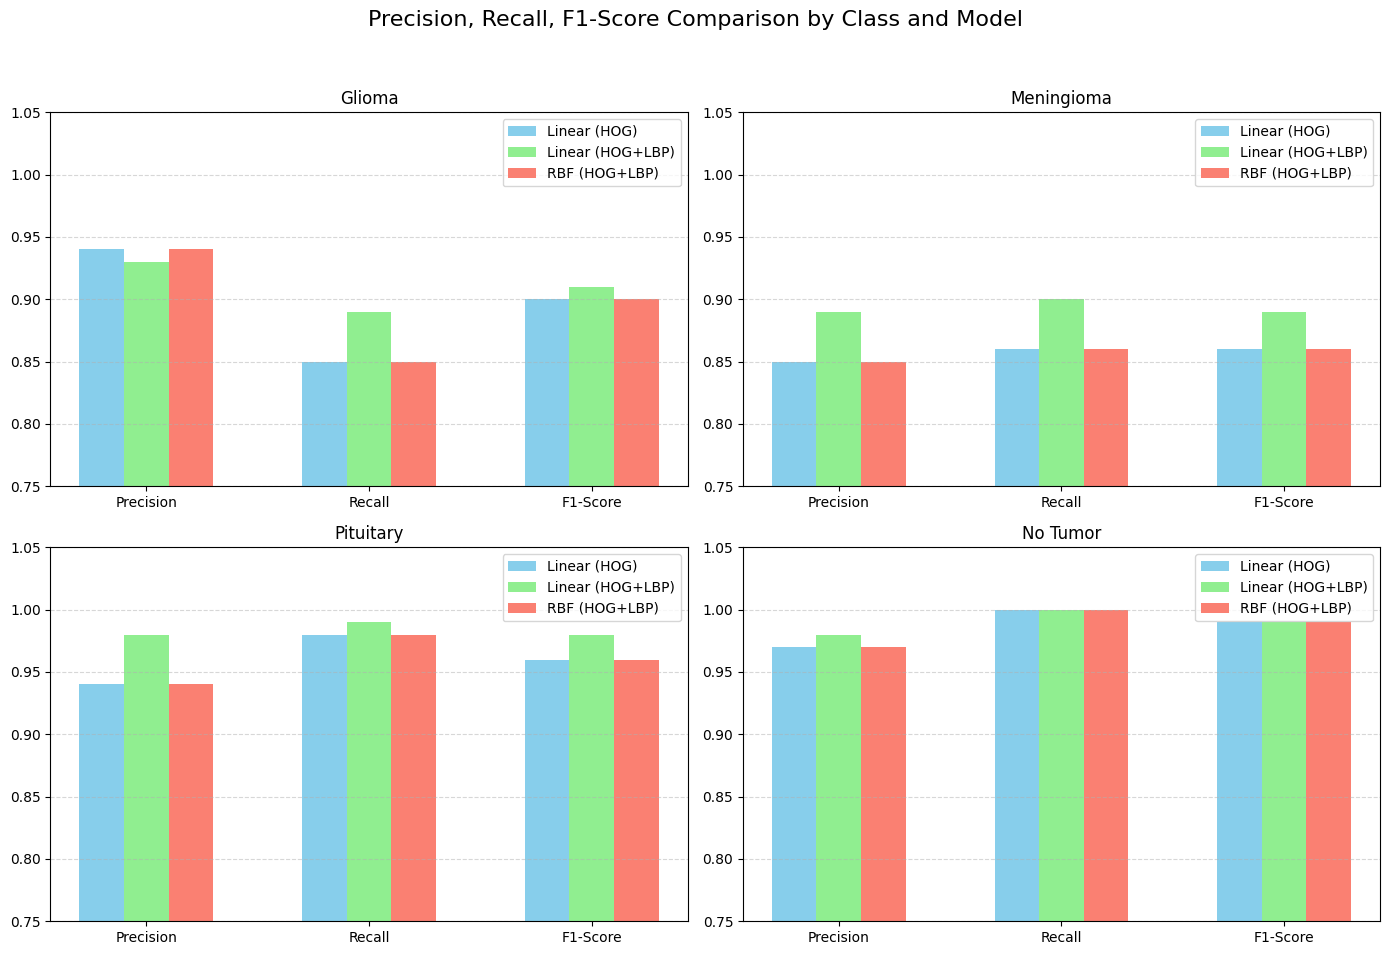

'/mnt/data/all_models_class_metrics_comparison.png'

In [ ]:
# Prepare grouped bar chart for precision, recall, F1 for all models and classes

# Data setup from classification reports
metrics = ['Precision', 'Recall', 'F1-Score']
classes = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

# Linear SVM (HOG only)
linear_hog = [
    [0.94, 0.85, 0.90],  # Glioma
    [0.85, 0.86, 0.86],  # Meningioma
    [0.94, 0.98, 0.96],  # Pituitary
    [0.97, 1.00, 0.99]   # No Tumor
]

# Linear SVM (HOG + LBP)
linear_combined = [
    [0.93, 0.89, 0.91],
    [0.89, 0.90, 0.89],
    [0.98, 0.99, 0.98],
    [0.98, 1.00, 0.99]
]

# RBF SVM (HOG + LBP)
rbf_combined = [
    [0.94, 0.85, 0.90],
    [0.85, 0.86, 0.86],
    [0.94, 0.98, 0.96],
    [0.97, 1.00, 0.99]
]

x = np.arange(len(metrics))  # Precision, Recall, F1
width = 0.2

# Plot for each class
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, class_name in enumerate(classes):
    axs[i].bar(x - width, linear_hog[i], width, label='Linear (HOG)', color='skyblue')
    axs[i].bar(x, linear_combined[i], width, label='Linear (HOG+LBP)', color='lightgreen')
    axs[i].bar(x + width, rbf_combined[i], width, label='RBF (HOG+LBP)', color='salmon')
    axs[i].set_title(f"{class_name}")
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(metrics)
    axs[i].set_ylim(0.75, 1.05)
    axs[i].legend()
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Precision, Recall, F1-Score Comparison by Class and Model", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


plt.show()




In [ ]:
import os
os.makedirs('/content/drive/MyDrive/brain_tumor_project/models', exist_ok=True)


In [ ]:
import joblib

# Save the linear SVM with HOG + LBP
joblib.dump(svm_combined, '/content/drive/MyDrive/brain_tumor_project/models/svm_hog_lbp_linear.pkl')


['/content/drive/MyDrive/brain_tumor_project/models/svm_hog_lbp_linear.pkl']